In [225]:
import numpy as np
import pandas as pd
import nibabel as nib
import os
import sys
from os import listdir
from os.path import isfile, join, exists
from scipy.spatial.distance import pdist, squareform
import scipy.io as sio
import scipy.stats as stats
from tqdm import tqdm
import time
import pymatreader
from IPython.core.debugger import set_trace
import copy
import h5py

import matplotlib.pyplot as plt

In [234]:
homedir = '/home/jacobpri/git/BOLD5000-GLMs/'
metric = 'reliability'
datasets = ['NSD','B5K']
versions = ['TYPEA_ASSUMEHRF', 'TYPEB_FITHRF', 'TYPEC_FITHRF_GLMDENOISE', 'TYPED_FITHRF_GLMDENOISE_RR']
#versions = ['TYPEA_ASSUMEHRF', 'TYPEB_FITHRF', 'TYPED_FITHRF_GLMDENOISE_RR']

opts = dict()

opts['NSD'] = dict()
opts['B5K'] = dict()

opts['NSD']['subjs'] = ['subj01','subj02','subj03','subj04']
opts['B5K']['subjs'] = ['CSI1','CSI2','CSI3']

opts['NSD']['dir'] = '09_08_20_one-sess_NSD'
opts['B5K']['dir'] = '08_24_20_five-sess'

colors = ['dodgerblue','orange','limegreen','tomato','black']

ft = 16


In [235]:
# load reliability data into struct

X = dict()

# iterate through datasets
for ds in tqdm(datasets):
    
    metricdir = join(homedir,'betas',opts[ds]['dir'],'metrics_v2')
    
    X[ds] = dict()
    
    # iterate through subjects
    for subj in opts[ds]['subjs']:
        
        X[ds][subj] = dict()

        subj_version_list = []
        
        # iterate through versions
        for version in versions:
            
            fn = join(metricdir, f'{subj}_{version}_{metric}.mat')
            assert(exists(fn))
            #print(fn)
            
            # add each version's reliability data to struct
            X[ds][subj][version] = sio.loadmat(fn)[metric]
            
            subj_version_list.append(X[ds][subj][version])
        
        # also add that subject's mean of all versions
        X[ds][subj]['mean'] = np.mean(np.stack(subj_version_list,axis=3),axis=3)
            
            

100%|██████████| 2/2 [00:01<00:00,  1.87it/s]


1573
1693
992
572
302
154
242


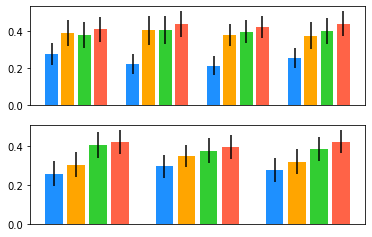

In [236]:
# figure 1: 

# NSD and BOLD5000 bar graphs showing average reliability by beta version per subject
# include voxels where version-averaged reliability > 0.3

threshold  = 0.3
topk = 1000

voxchoice = 'threshold'
method = 'median'


plt.figure()
c = 1

# iterate through datasets
for ds in datasets:
    
    plt.subplot(len(datasets),1,c)
    
    subj_version_means = []
    subj_version_sems = []
        
    # iterate through subjects
    for subj in opts[ds]['subjs']:
        
        subj_mean_metric = X[ds][subj]['mean'].reshape(-1)
        validvox = np.logical_not(np.isnan(subj_mean_metric))

        if voxchoice == 'threshold':
            included_voxels = subj_mean_metric[validvox] > threshold
            print(np.sum(included_voxels))
        elif voxchoice == 'topk':
            included_voxels = np.argsort(subj_mean_metric[validvox])[-topk:]
            print(len(included_voxels))
        
        # iterate through versions
        for version in versions:
            this_version = X[ds][subj][version].reshape(-1)[validvox]
            
            if method == 'mean':
                subj_version_means.append(np.mean(this_version[included_voxels]))
            elif method == 'median':
                subj_version_means.append(np.median(this_version[included_voxels]))
                
            subj_version_sems.append(np.std(this_version[included_voxels])) #/ np.sqrt(len(included_voxels)))
            
        subj_version_means.append(np.nan)
        subj_version_sems.append(np.nan)
        
            
    plt.bar(np.arange(len(subj_version_means)),subj_version_means,color=colors,yerr=subj_version_sems)
    plt.xticks([])

    c+=1


/home/jacobpri/Gating/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in greater
/home/jacobpri/Gating/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: Mean of empty slice


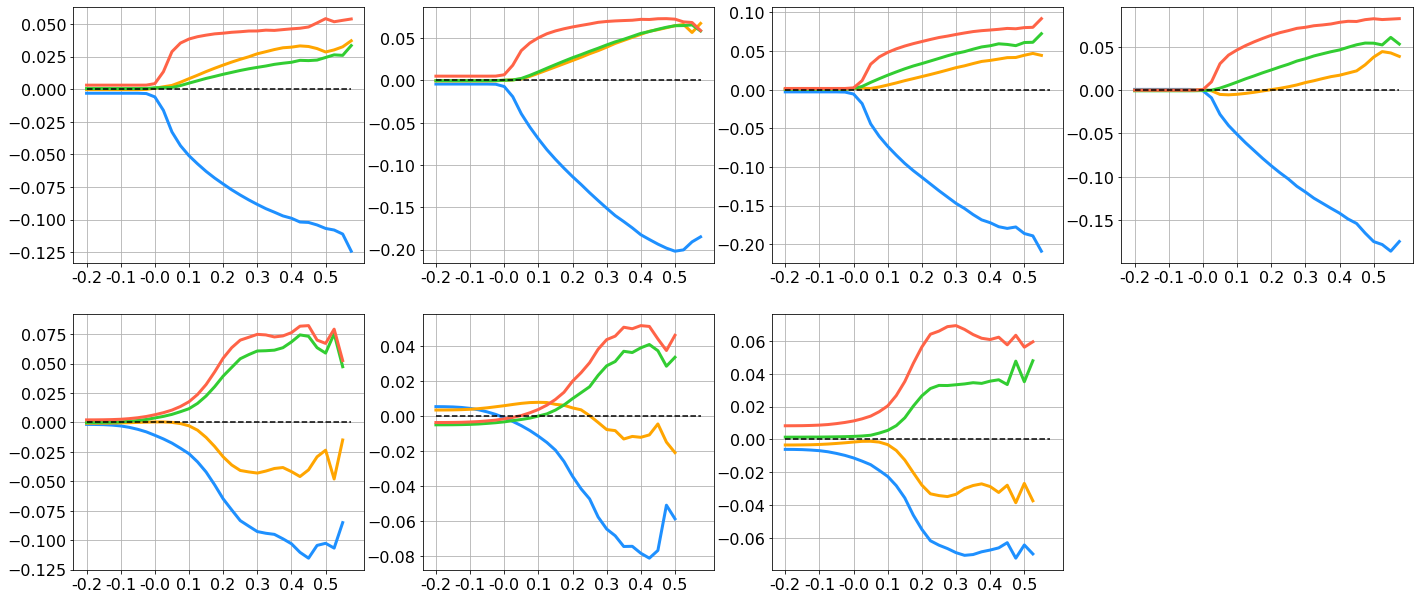

In [238]:
# figure 1: 

# NSD and BOLD5000 bar graphs showing average reliability by beta version per subject
# include voxels where version-averaged reliability > 0.3

bins  = np.round(np.arange(-0.2,0.6,0.025),3)

method = 'mean'

allsubj_diffs = dict()

plt.figure(figsize=(24,16))
c = 1

# iterate through datasets
for ds in datasets:
    
    allsubj_diffs[ds] = dict()
    
    for version in versions:
        allsubj_diffs[ds][version] = []
            
    # iterate through subjects
    for subj in opts[ds]['subjs']:
        
        plt.subplot(len(ds),len(opts['NSD']['subjs']),c)
        
        subj_mean_metric = X[ds][subj]['mean']
        
        subj_version_diffs = []
        
        # iterate through versions
        v=0
        for version in versions:
            
            this_version = X[ds][subj][version]
            this_version_diffs = []
            for val in bins:
                validvox = subj_mean_metric > val
            
                if method == 'mean':
                    this_version_diffs.append(np.nanmean(this_version[validvox] - subj_mean_metric[validvox]))
                elif method == 'median':
                    this_version_diffs.append(np.nanmedian(this_version[validvox] - subj_mean_metric[validvox]))
            
            subj_version_diffs.append(this_version_diffs)
            plt.plot(this_version_diffs,linewidth=3,color = colors[v])
            v+=1
            
            allsubj_diffs[ds][version].append(this_version_diffs)
        
        c+=1
        plt.plot(np.zeros((len(bins),)),'k--')
        plt.xticks(np.arange(len(bins))[::4],np.array(bins[::4]),fontsize=ft-4);
        #if ds == 'NSD':
        #    plt.ylim([-0.21,0.21])
        #else:
        #    plt.ylim([-0.15,0.15])
        plt.xticks(fontsize=ft)
        plt.yticks(fontsize=ft)
        plt.grid('on')                     
    

/home/jacobpri/Gating/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


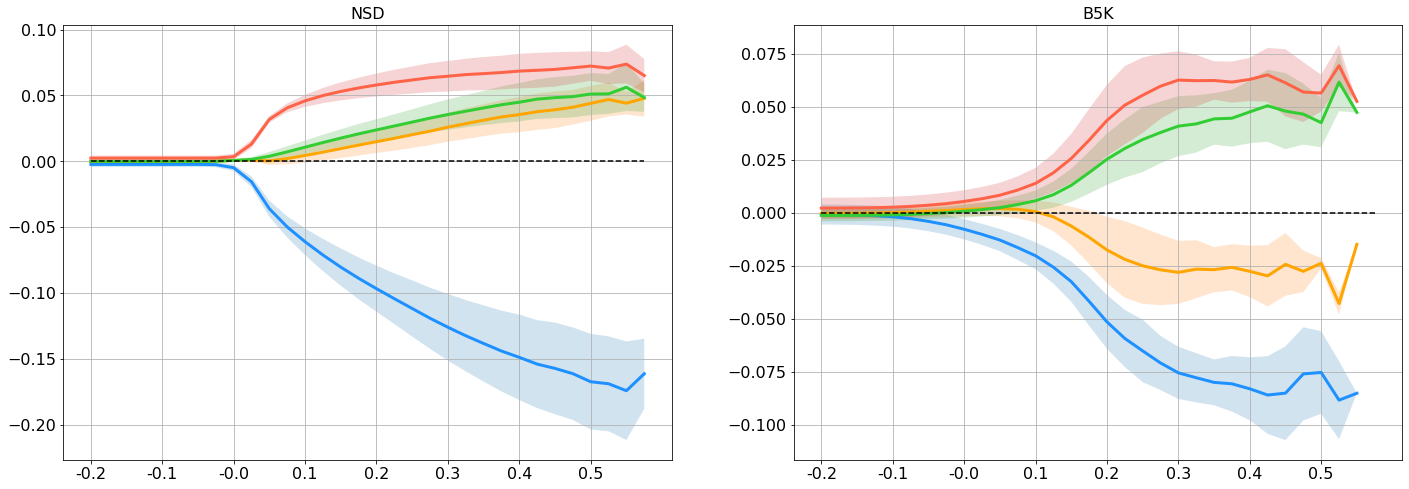

In [239]:
plt.figure(figsize=(24,8))
c = 1
for ds in datasets:
    plt.subplot(1,2,c)
    v=0
    for version in versions:
        this_version = allsubj_diffs[ds][version]
        mean_version = np.nanmean(np.stack(this_version,axis=1),axis=1)
        std_version = np.nanstd(np.stack(this_version,axis=1),axis=1)
        plt.plot(mean_version,linewidth=3,color = colors[v])
        plt.fill_between(np.arange(len(bins)),mean_version-std_version,mean_version+std_version,alpha=0.2)
        
        v+=1
    plt.plot(np.zeros((len(bins),)),'k--')
    plt.xticks(np.arange(len(bins))[::4],np.array(bins[::4]),fontsize=ft-4);
    #if ds == 'NSD':
    #    plt.ylim([-0.21,0.21])
    #else:
    #    plt.ylim([-0.15,0.15])
    plt.xticks(fontsize=ft)
    plt.yticks(fontsize=ft)
    plt.title(ds,fontsize=ft)
    plt.grid('on')  
    c+=1

In [269]:
# figure 2: ROI analysis

opts['NSD']['rois'] = ['nsdgeneral','lh.nsdgeneral','rh.nsdgeneral','lh.prf-visualrois','rh.prf-visualrois',
                       'lh.floc-faces','rh.floc-faces','lh.floc-places','rh.floc-places',
                       'lh.floc-words','rh.floc-words']
opts['B5K']['rois'] = ['LHEarlyVis','RHEarlyVis','LHLOC','RHLOC','LHOPA','RHOPA',
                       'LHPPA','RHPPA','LHRSC','RHRSC']

# load reliability data into struct
R = dict()

# iterate through datasets
for ds in tqdm(datasets):
    
    metricdir = join(homedir,'betas',opts[ds]['dir'],'metrics_v2')
    
    R[ds] = dict()
    
    # iterate through subjects
    for subj in opts[ds]['subjs']:
        
        R[ds][subj] = dict()
        
        # iterate through versions
        for version in versions:
            
            fn = join(metricdir, f'{subj}_{version}_{metric}.mat')
            assert(exists(fn))
            #print(fn)
            
            this_version = sio.loadmat(fn)[metric]
            
            # add each version's reliability data to struct
            R[ds][subj][version] = dict()
            R[ds][subj]['masks'] = dict()
            R[ds][subj][version]['whole_brain'] = this_version
                        
            for roi in opts[ds]['rois']:
                if ds == 'B5K':
                    maskdir = f'/lab_data/tarrlab/common/datasets/BOLD5000/BIDS/derivatives/spm/sub-{subj}'
                    fn = join(maskdir,f'sub-{subj}_mask-{roi}.nii.gz')
                    if not exists(fn):

                        # deal with typos in bold5000 roi filenames
                        if 'LHLOC' in fn:
                            roi_ = 'LHLO'
                        elif 'RHLOC' in fn:
                            roi_ = 'RHLO'
                        elif 'RHRSC' in fn:
                            roi_ = 'RHRRSC'
                        else:
                            assert(1==2)
                        fn = join(maskdir,f'sub-{subj}_mask-{roi_}.nii.gz')
                    
                elif ds == 'NSD':
                    maskdir = f'/lab_data/tarrlab/common/datasets/NSD/nsddata/ppdata/{subj}/func1pt8mm/roi'
                    fn = join(maskdir,f'{roi}.nii.gz')
                    
                assert(exists(fn))
                mask = nib.load(fn).get_data()
                R[ds][subj]['masks'][roi] = mask
                R[ds][subj][version][roi] = this_version[mask>0] 
                                

100%|██████████| 2/2 [00:05<00:00,  2.57s/it]


100%|██████████| 2/2 [00:03<00:00,  1.60s/it]


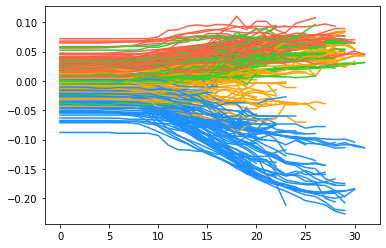

In [270]:
bins  = np.round(np.arange(-0.2,0.6,0.025),3)

method = 'median'
min_nvox = 5

# dictionary for storing the difference of a given version from the mean across bins
# for each subj/ROI
D = dict() 
plt.figure()

# iterate through datasets
for ds in tqdm(datasets):
        
    D[ds] = dict()
        
    for roi in opts[ds]['rois']:
        
        D[ds][roi] = dict()
        
        # iterate through subjects
        for subj in opts[ds]['subjs']:
            
            D[ds][roi][subj] = dict()
            
            # iterate through versions to compute the mean version
            subj_versions = []
            for version in versions:
                D[ds][roi][subj][version] = dict()
                D[ds][roi][subj][version]['binmeans'] = []
                D[ds][roi][subj][version]['binstds'] = []
                
                subj_versions.append(R[ds][subj][version][roi])

            subj_mean_metric = np.nanmean(np.stack(subj_versions,axis=1),axis=1)
            
            # iterate through versions to get the diff from mean in each bin
            v=0
            for version in versions:
                
                for val in bins:
                    validvox = subj_mean_metric > val
                    
                    if np.sum(validvox) > min_nvox:
            
                        if method == 'mean':
                            D[ds][roi][subj][version]['binmeans'].append(np.nanmean(R[ds][subj][version][roi][validvox] - subj_mean_metric[validvox]))
                        elif method == 'median':
                            D[ds][roi][subj][version]['binmeans'].append(np.nanmedian(R[ds][subj][version][roi][validvox] - subj_mean_metric[validvox]))
                        
                        D[ds][roi][subj][version]['binstds'].append(np.nanstd(R[ds][subj][version][roi][validvox] - subj_mean_metric[validvox]))
                        
                    else:
                        D[ds][roi][subj][version]['binmeans'].append(np.nan)
                        D[ds][roi][subj][version]['binstds'].append(np.nan)
                        
                plt.plot(D[ds][roi][subj][version]['binmeans'],color=colors[v])
                v+=1

/home/jacobpri/Gating/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice


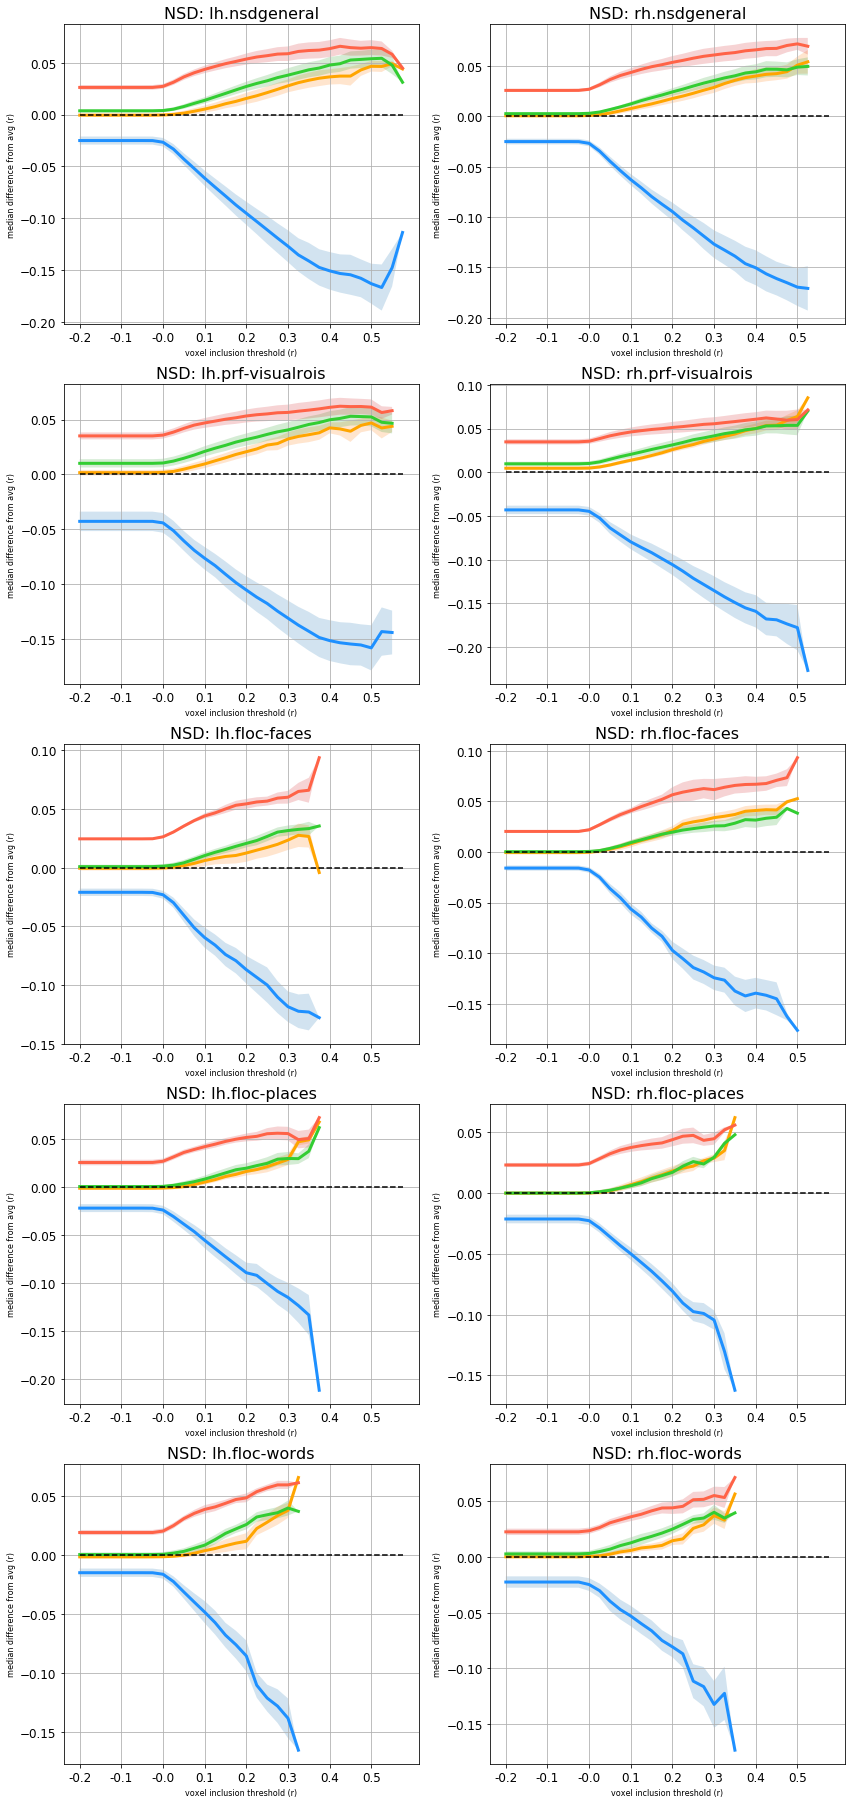

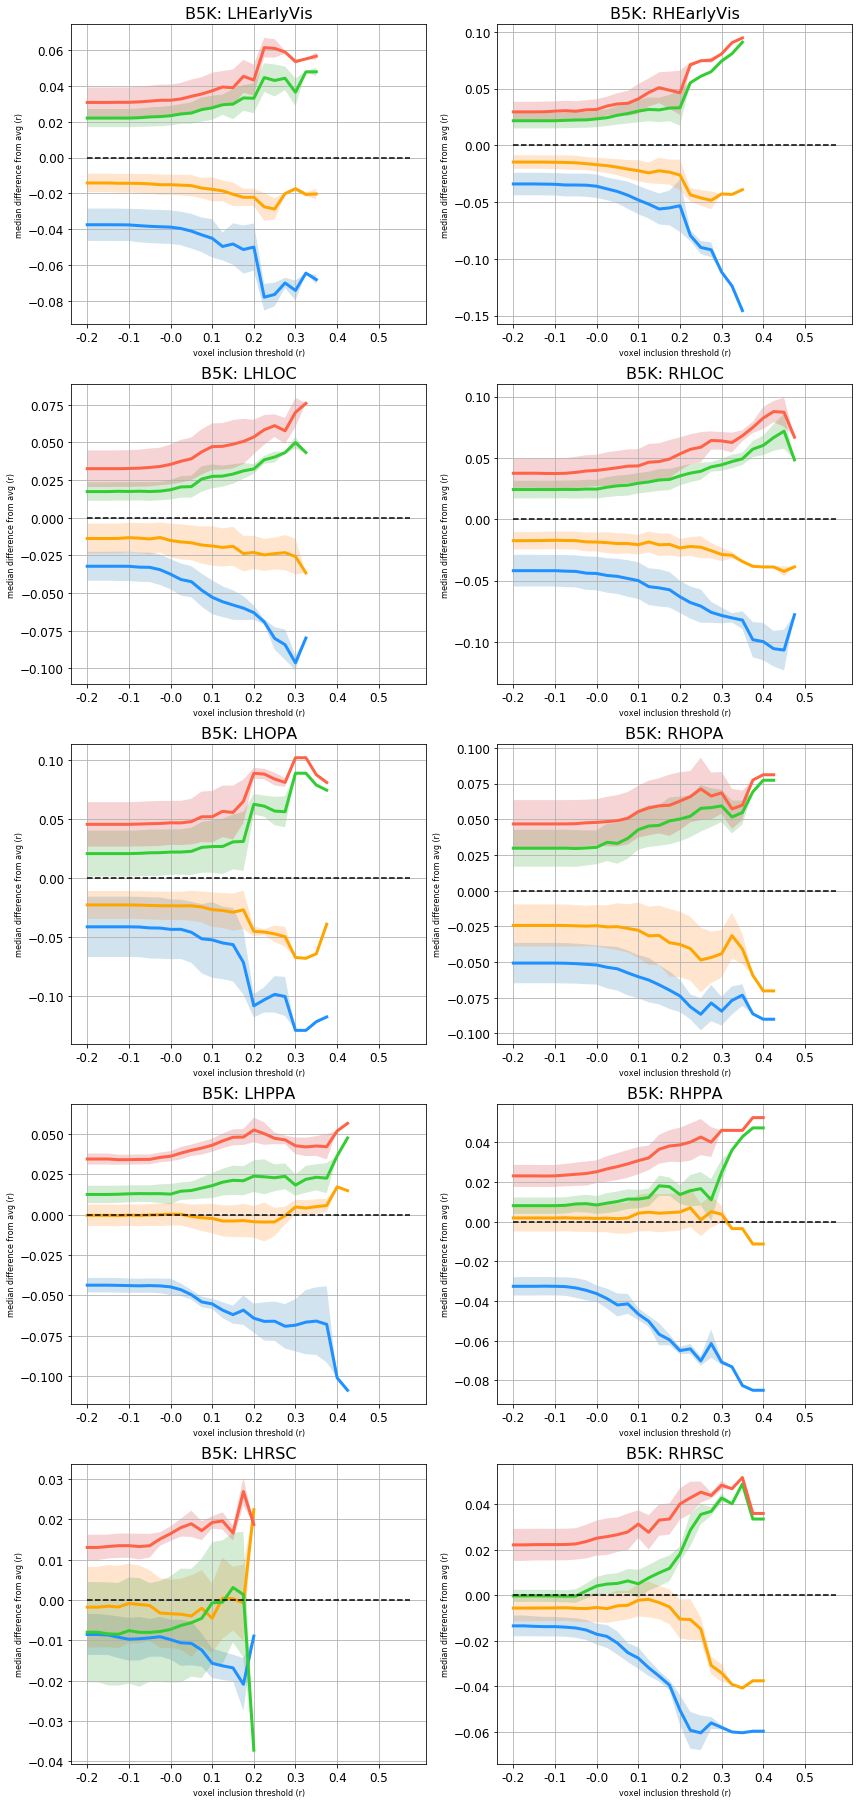

In [273]:
variability_method = 'std_of_means' # either std of subject means or mean of subject stds
for ds in datasets:
    plt.figure(figsize=(14,32))
    c=1
    for roi in opts[ds]['rois']:
        if roi == 'nsdgeneral':
            continue
        else:
            plt.subplot(5,2,c)

            v=0
            for version in versions:
                subj_versions_means = []
                subj_versions_stds = []
                for subj in opts[ds]['subjs']:
                    subj_versions_means.append(D[ds][roi][subj][version]['binmeans'])
                    subj_versions_stds.append(D[ds][roi][subj][version]['binstds'])

                subj_mean_version = np.nanmean(np.stack(subj_versions_means,axis=1),axis=1)

                if variability_method == 'mean_of_stds':
                    subj_std_version = np.nanmean(np.stack(subj_versions_stds,axis=1),axis=1) / np.sqrt(len(opts[ds]['subjs']))
                elif variability_method == 'std_of_means':
                    subj_std_version = np.nanstd(np.stack(subj_versions_means,axis=1),axis=1) / np.sqrt(len(opts[ds]['subjs']))

                plt.plot(subj_mean_version,linewidth=3,color=colors[v])
                plt.fill_between(np.arange(len(bins)),subj_mean_version-subj_std_version,subj_mean_version+subj_std_version,alpha=0.2)


                v+=1

            plt.plot(np.zeros((len(bins),)),'k--')
            plt.xticks(np.arange(len(bins))[::4],np.array(bins[::4]),fontsize=ft-4);
            #if ds == 'NSD':
            #    plt.ylim([-0.21,0.21])
            #else:
            #    plt.ylim([-0.15,0.15])
            plt.xticks(fontsize=ft-4)
            plt.yticks(fontsize=ft-4)
            plt.grid('on')  
            plt.title(f'{ds}: {roi}',fontsize=ft)
            plt.xlabel('voxel inclusion threshold (r)',fontsize=8)
            plt.ylabel('median difference from avg (r)',fontsize=8)
            c+=1

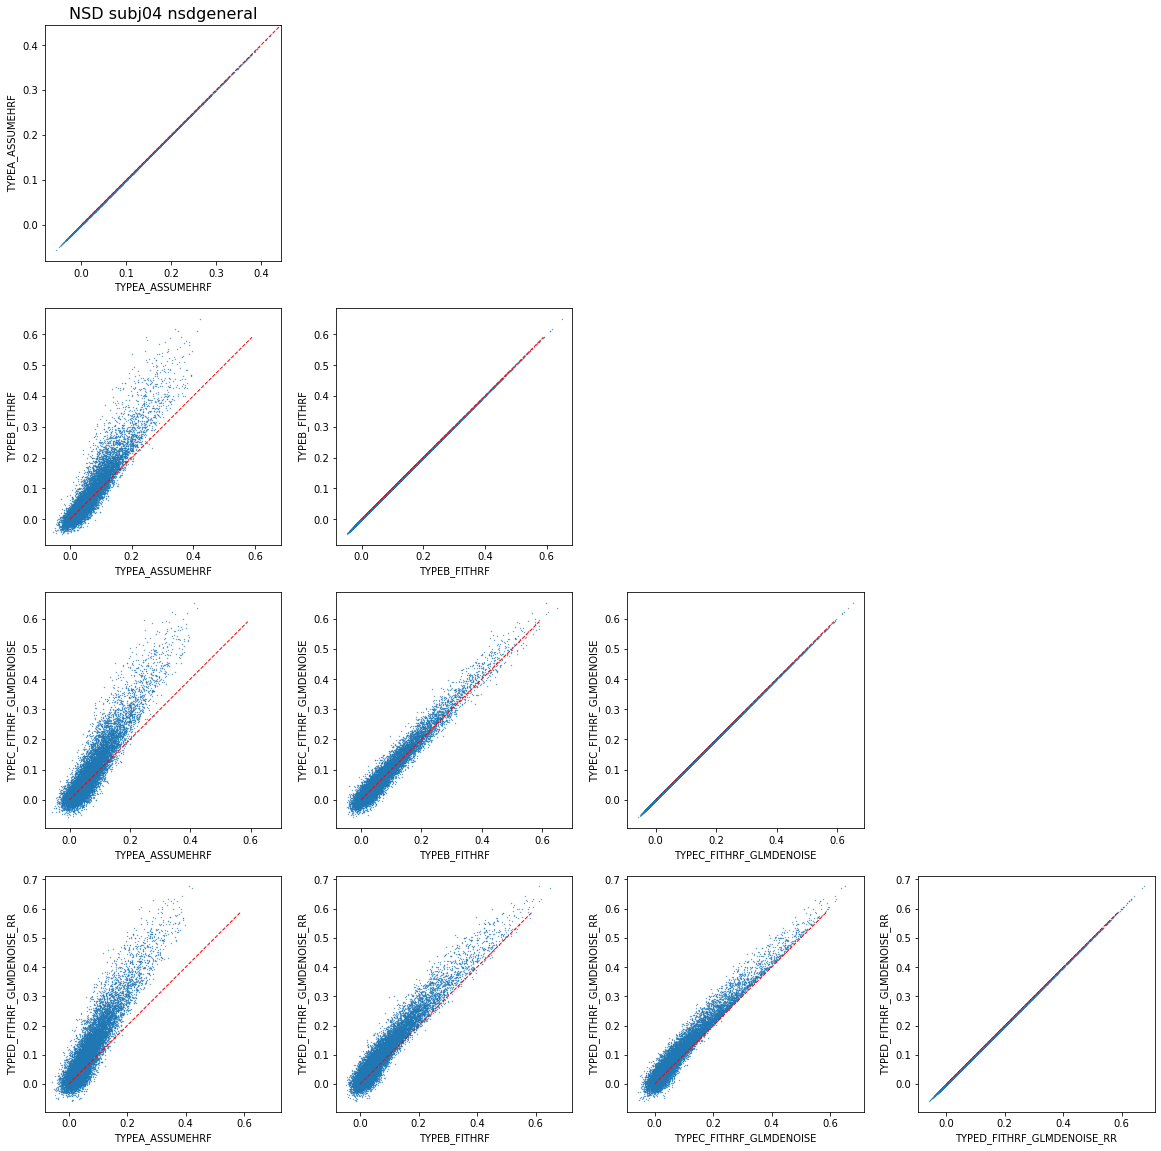

In [274]:
ds_ = ['NSD']
subjs_ = ['subj04']
#rois_ = ['rh.floc-faces']
rois_ = ['nsdgeneral']
n = len(versions)

# iterate through datasets
for ds in ds_:
            
    # iterate through subjects
    for subj in subjs_:
                
        for roi in rois_:
            
            plt.figure(figsize=(20,20))
            
            c = 1
            a = 0
            # iterate through versions
            for versionA in versions:
                a += 1
                b = 0
                for versionB in versions:
                    b += 1
                    if b <= a:
                        plt.subplot(n,n,c)
                        plt.scatter(R[ds][subj][versionB][roi],R[ds][subj][versionA][roi],0.1)
                        plt.axis('square')
                        plt.xlabel(versionB)
                        plt.ylabel(versionA)
                        plt.plot(np.arange(0,0.6,0.01),np.arange(0,0.6,0.01),'r--',linewidth=1)
                        if c == 1:
                            plt.title(f'{ds} {subj} {roi}',fontsize=ft)
                    c+=1
                    
                        
            
                
                
                

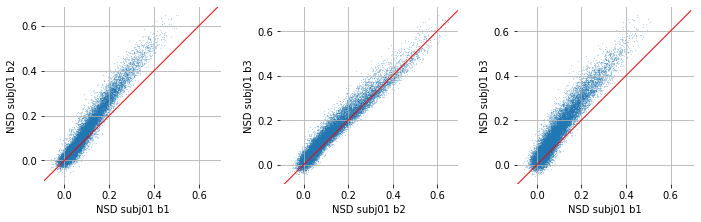

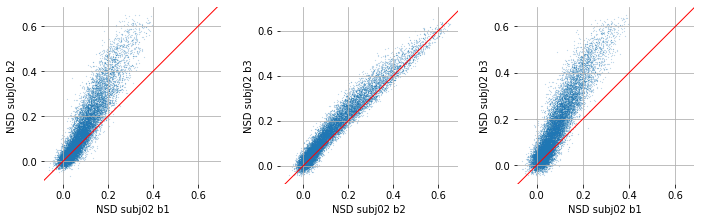

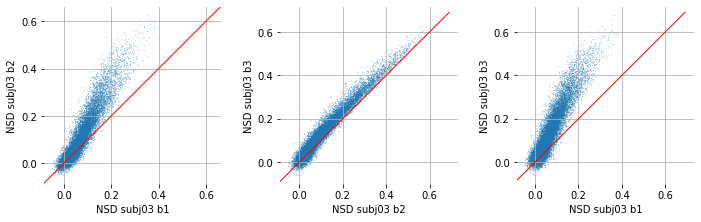

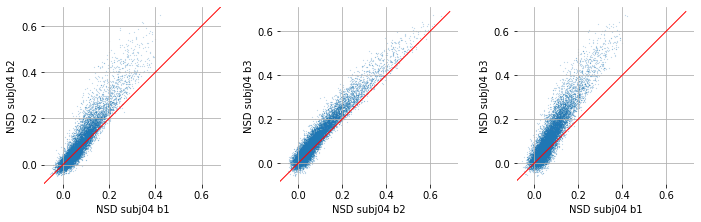

In [313]:
ds_ = ['NSD']
subjs_ = opts['NSD']['subjs']
#rois_ = ['rh.floc-faces']
rois_ = ['nsdgeneral']
ns = len(subjs_)
comparisons = [(versions[0],versions[1]), (versions[1],versions[3]), (versions[0],versions[3])]
nc = len(comparisons)
labels = ['b1', 'b2', 'b3']
labels = [(labels[0],labels[1]), (labels[1],labels[2]), (labels[0],labels[2])]

# iterate through datasets
for ds in ds_:
            
    # iterate through subjects
    for subj in subjs_:
                
        for roi in rois_:
            
            plt.figure(figsize=(12,15))
            c = 1
            l = 0
            for comp in comparisons:
                plt.subplot(ns,nc,c)
                plt.grid('on')
                plt.scatter(R[ds][subj][comp[0]][roi],R[ds][subj][comp[1]][roi],0.01)
                plt.axis('square')
                plt.xlabel(f'{ds} {subj} {labels[l][0]}')
                plt.ylabel(f'{ds} {subj} {labels[l][1]}')
                plt.plot(np.arange(-0.1,0.7,0.01),np.arange(-0.1,0.7,0.01),'r',linewidth=1)
                #plt.title(f'{ds} {subj} {roi}',fontsize=ft)
                plt.box('off')
                plt.yticks(np.round(np.arange(0,0.8,0.2),2),np.round(np.arange(0,0.8,0.2),2))
                plt.yticks(np.round(np.arange(0,0.8,0.2),2),np.round(np.arange(0,0.8,0.2),2))
                # get rid of the frame
                for spine in plt.gca().spines.values():
                    spine.set_visible(False)
                
                c+=1
                l+=1
            
